# Multi Input

In [2]:
from dataset import get_train, get_val, get_test

2023-06-12 21:21:51.261070: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 21:21:51.308879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:21:52.094380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import pydot
import graphviz

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def plot_acc_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['accuracy'])
    plt.plot(trainHistory.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Accuracy")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [6]:
def plot_loss_curve(trainHistory, savefigname=None):
    plt.figure(figsize=(8,6))
    plt.plot(trainHistory.history['loss'])
    plt.plot(trainHistory.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.grid()
    plt.title("Model Loss")
    if savefigname:
        plt.savefig(savefigname, bbox_inches='tight')
    plt.show()

In [7]:
HEIGHT = 825
WIDTH = 825

In [8]:
train_generator_normal = get_train('normal')
train_images_normal = train_generator_normal


validation_generator_normal = get_val('normal')
val_images_normal = validation_generator_normal
test_generator_normal = get_test('normal')
test_images_normal = test_generator_normal

train_generator_canny = get_train('canny')
train_images_canny = train_generator_canny
validation_generator_canny = get_val('canny')
val_images_canny = validation_generator_canny
test_generator_canny = get_test('canny')
test_images_canny = test_generator_canny

train_generator_opencv = get_train('opencv')
train_images_opencv = train_generator_opencv
validation_generator_opencv = get_val('opencv')
val_images_opencv = validation_generator_opencv
test_generator_opencv = get_test('opencv')
test_images_opencv = test_generator_opencv

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
def create_convolution_layers(input_img, input_shape):
  model = keras.layers.ZeroPadding2D(((6, 0), (6, 0)), input_shape=input_shape)(input_img)
  # Data augmentation
  #model = tf.keras.layers.RandomFlip("horizontal_and_vertical")(model)
  #model = tf.keras.layers.RandomRotation(0.2)(model)  # fraction of 2 pi
  #model = tf.keras.layers.RandomContrast(0.2)(model)
  model = keras.layers.Conv2D(16, (4, 4), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2), (2, 2))(model)
  model = keras.layers.Dropout(0.1)(model)
  model = keras.layers.Conv2D(8, (4, 4), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2), (1, 1))(model)
  model = keras.layers.Dropout(0.2)(model)
    
  return model

In [10]:
def create_canny_convolution_layers(input_img, input_shape):
  model = keras.layers.ZeroPadding2D(((6, 0), (6, 0)), input_shape=input_shape)(input_img)
  model = keras.layers.Conv2D(16, (4, 4), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2), (2, 2))(model)
  model = keras.layers.Dropout(0.1)(model)
  model = keras.layers.Conv2D(8, (4, 4), activation='relu')(model)
  model = keras.layers.MaxPooling2D((2, 2), (1, 1))(model)
  model = keras.layers.Dropout(0.2)(model)
    
  return model

In [11]:
def create_opencv_convolution_layers(input_img, input_shape):
  model = keras.layers.ZeroPadding2D(((0, 0), (0, 0)), input_shape=input_shape)(input_img)
  model = keras.layers.Conv2D(8, (3, 3), activation='relu')(model)
  model = keras.layers.MaxPooling2D((4, 4), (2, 2))(model)
  model = keras.layers.Dropout(0.2)(model)

  return model

In [12]:
# Combined model
input_shape_normal = (HEIGHT, WIDTH, 3)
input_shape_canny = (HEIGHT, WIDTH, 1)
input_shape_opencv = (HEIGHT, WIDTH, 1)

normal_input = keras.layers.Input(shape=input_shape_normal)
canny_input = keras.layers.Input(shape=input_shape_canny)
opencv_input = keras.layers.Input(shape=input_shape_opencv)

model_normal = create_convolution_layers(normal_input, input_shape_normal)
model_canny = create_canny_convolution_layers(canny_input, input_shape_canny)
model_opencv = create_opencv_convolution_layers(opencv_input, input_shape_opencv)
conv = keras.layers.Concatenate()([model_normal, model_canny, model_opencv])

conv = keras.layers.GlobalAveragePooling2D()(conv)
dense = keras.layers.Dense(64)(conv)
dense = keras.layers.Dropout(0.25)(dense)
dense = keras.layers.ReLU()(dense)
output = keras.layers.Dense(1, activation='sigmoid')(dense)

model = keras.models.Model(inputs=[normal_input, canny_input, opencv_input], outputs=output)

opt = keras.optimizers.Adam(learning_rate=0.000075)


2023-06-12 21:21:54.945145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78918 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 825, 825, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 825, 825, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 831, 831, 3)  0          ['input_1[0][0]']                
                                                                                              

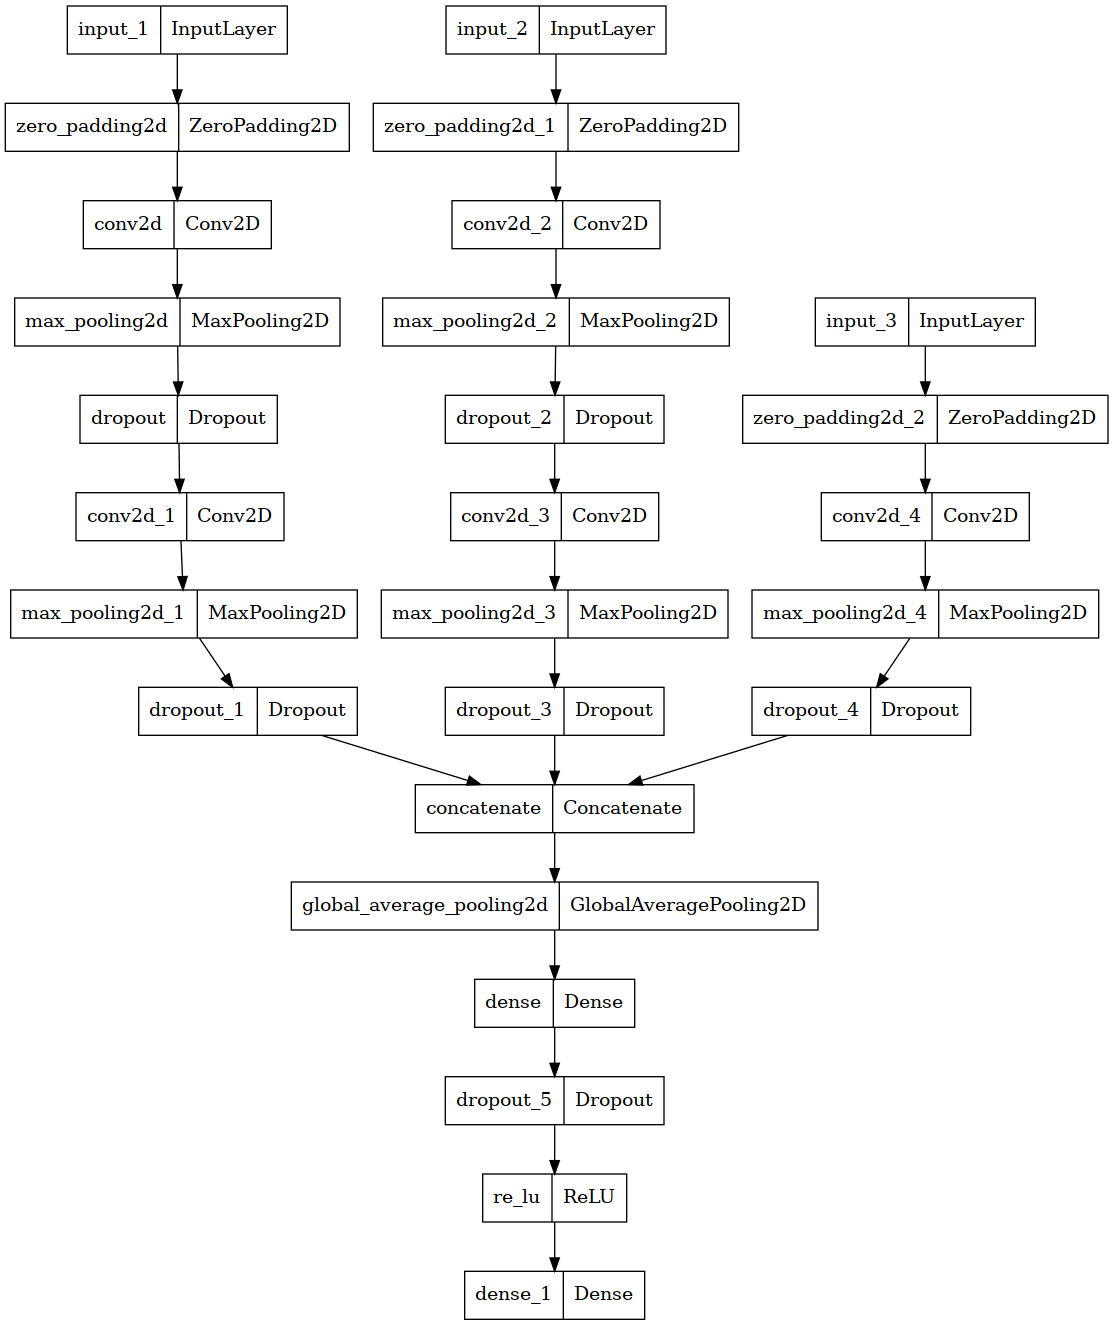

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
x_train_images_normal, y_train_images_normal = next(train_images_normal)
x_val_images_normal, y_val_images_normal = next(val_images_normal)
x_test_images_normal, y_test_images_normal = next(test_images_normal)

In [17]:
x_train_images_canny, y_train_images_canny = next(train_images_canny)
x_val_images_canny, y_val_images_canny = next(val_images_canny)
x_test_images_canny, y_test_images_canny = next(test_images_canny)

In [18]:
x_train_images_opencv, y_train_images_opencv = next(train_images_opencv)
x_val_images_opencv, y_val_images_opencv = next(val_images_opencv)
x_test_images_opencv, y_test_images_opencv = next(test_images_opencv)

In [19]:
print(x_train_images_normal.shape)
print(x_train_images_canny.shape)
print(x_train_images_opencv.shape)

(400, 825, 825, 3)
(400, 825, 825, 1)
(400, 825, 825, 1)


In [20]:
best_weights_file="weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(best_weights_file, monitor='accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=75, verbose=1, mode='max')

callbacks = [earlyStopping]

trainHistory = model.fit([x_train_images_normal, x_train_images_canny, x_train_images_opencv], y_train_images_normal,
          epochs=250,
          callbacks=callbacks,
          batch_size=25,
          verbose=0,
          steps_per_epoch=5,
          validation_data=([x_val_images_normal, x_val_images_canny, x_val_images_opencv], y_val_images_normal),
          shuffle=True)

2023-06-12 21:22:29.418926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-12 21:22:35.945466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-12 21:22:36.824169: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-12 21:22:38.113102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-12 21:22:38.124138: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f22357ac2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-12 21:22:38.124174: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0

In [21]:
final_loss, final_acc = model.evaluate([x_test_images_normal, x_test_images_canny, x_test_images_opencv], y_test_images_normal, verbose=1)
print("Test loss: {0:.2f}, test accuracy: {1:.2f}".format(final_loss, final_acc)) 

4/4 [==============================] - 2s 195ms/step - loss: 0.4366 - accuracy: 0.7300
Test loss: 0.44, test accuracy: 0.73


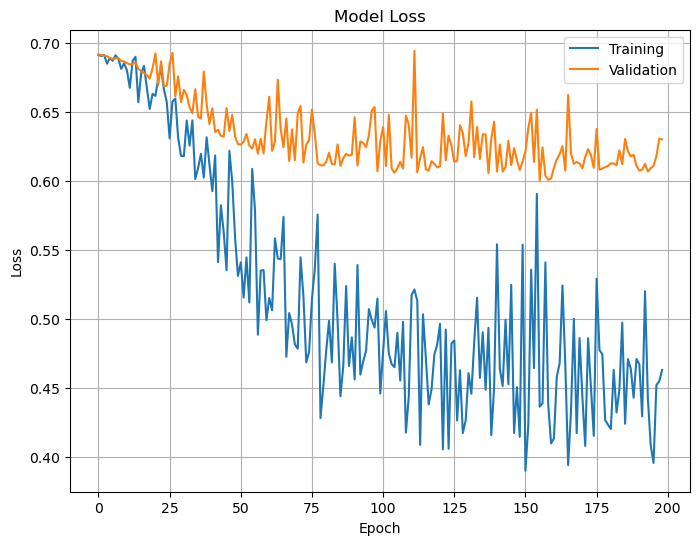

In [22]:
plot_loss_curve(trainHistory=trainHistory)

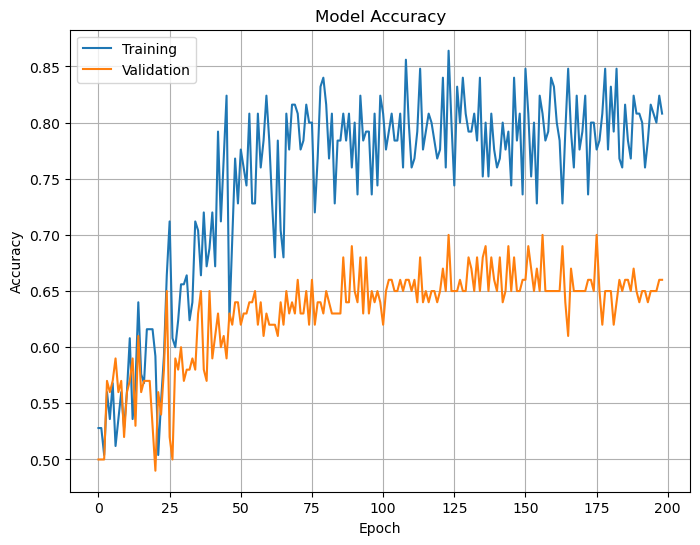

In [23]:
plot_acc_curve(trainHistory=trainHistory)

---